In [8]:
import os
import sys
import argparse
from io import StringIO
from typing import Optional
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

✅ 原始数据形状: (1048560, 8)
✅ 样本形状: (1432, 8192)
✅ 标签形状: (1432, 4)
✅ 前3个标签示例:
 [[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
🎉 已保存为 D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\health_20_0.npy


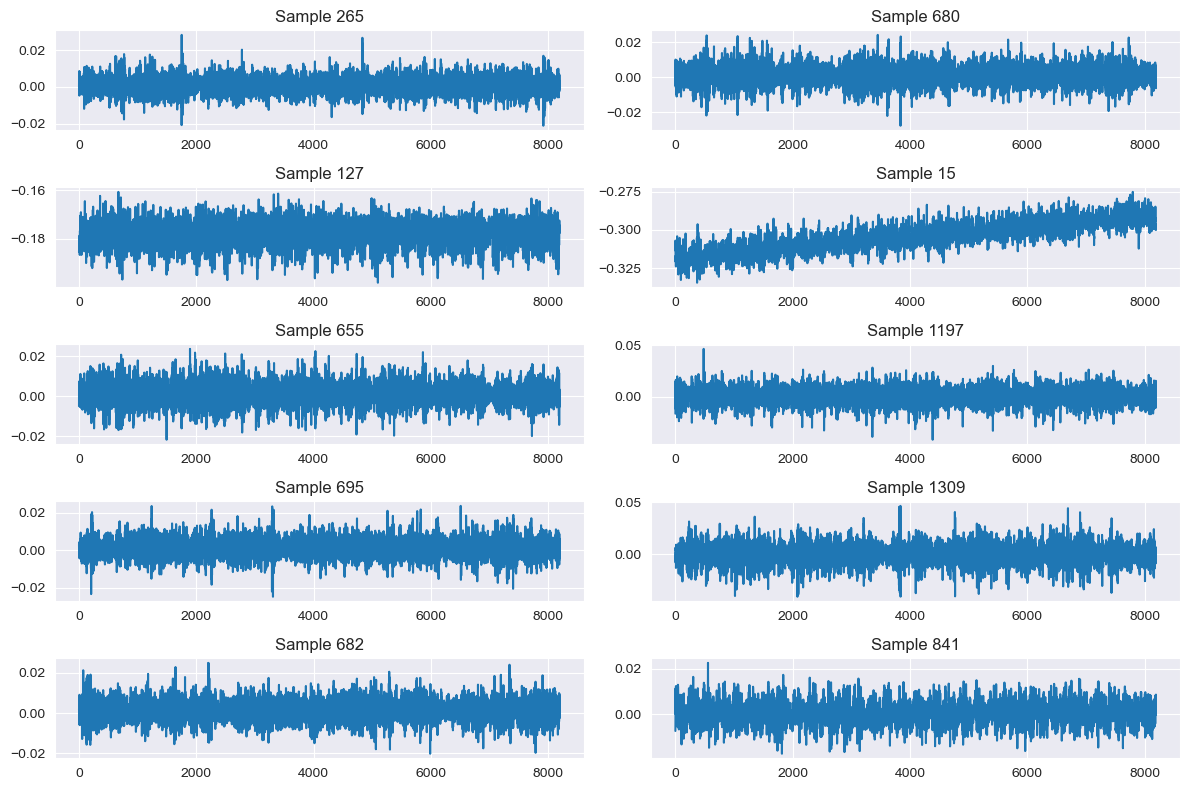

In [78]:
# -----------------------------
# 每个通道都截取8196个
# -----------------------------

# === 1. 读取CSV（直接从第17行开始）===
csv_path = r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\outer_20_0.csv"  # 修改为你的文件路径
# 1. 读取 Excel
file_path = r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\health_20_0.csv"
# === 2. 找到 "Data" 行的起始位置 ===
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

data_start = None
for i, line in enumerate(lines):
    if line.strip().startswith("Data"):
        data_start = i + 1
        break

if data_start is None:
    raise ValueError("❌ 未找到 'Data' 行，请检查文件格式")

# === 3. 读取数据部分 ===
data_lines = lines[data_start:]
data = []
for line in data_lines:
    # 替换各种分隔符并切分
    parts = [p for p in line.replace(",", " ").replace("\t", " ").split() if p]
    if len(parts) >= 8:
        data.append([float(x) for x in parts[:8]])  # 取前8个通道

data = np.array(data)
print("✅ 原始数据形状:", data.shape)  # (N, 8)

# === 3. 滑动窗口分割 ===
segment_len = 8192
num_segments = 179
samples = []

for ch in range(data.shape[1]):  # 8个通道
    channel_data = data[:, ch]
    total_len = len(channel_data)

    # 如果数据长度不足以整除，自动计算滑动步长
    if total_len <= segment_len:
        raise ValueError(f"❌ 通道 {ch} 数据长度太短: {total_len}")
    step = (total_len - segment_len) // (num_segments - 1)
    if step < 1:
        step = 1  # 保护

    for i in range(num_segments):
        start = i * step
        end = start + segment_len
        if end > total_len:
            end = total_len
            start = end - segment_len
        segment = channel_data[start:end]
        samples.append(segment)

samples = np.array(samples, dtype=np.float32)
print("✅ 样本形状:", samples.shape)  # (1432, 8192)

# === 4. 生成标签（每个样本都是 [0, 0, 1, 1]） ===
labels = np.tile(np.array([1, 0, 0, 0]), (samples.shape[0], 1)).astype(np.int8)
print("✅ 标签形状:", labels.shape)
print("✅ 前3个标签示例:\n", labels[:3])

# === 5. 保存为 .npy 文件 ===
save_path = r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\health_20_0.npy"
np.save(save_path, {"data": samples, "label": labels})
print(f"🎉 已保存为 {save_path}")

# === 6. 随机展示10个波形 ===
indices = np.random.choice(samples.shape[0], 10, replace=False)
plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    plt.plot(samples[idx])
    plt.title(f"Sample {idx}")
    plt.tight_layout()
plt.show()



In [79]:
loaded = np.load(r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\health_20_0.npy", allow_pickle=True).item()
print(loaded["data"].shape)   # (720, 8192)
print(loaded["label"].shape)  # (720,)
print(np.unique(loaded["label"], axis=0))  # [0 0 1 1]

(1432, 8192)
(1432, 4)
[[1 0 0 0]]


In [114]:
import os
import math
import numpy as np
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [115]:
# -------------------------
# 1) Feature extractor (1D DCNN)
# -------------------------
class FeatureExtractor1D(nn.Module):
    """
    Two-layer 1D CNN feature extractor.
    Default config inspired by paper: you can change channels/kernels as needed.
    Input: (batch, 1, seq_len)
    Output: feature matrix shape (batch, K_l, R_l)  (we will keep as (batch, K, L))
    """
    def __init__(self,
                 in_channels=1,
                 conv1_out=256, conv1_kernel=64, conv1_stride=1,
                 pool1_kernel=16, pool1_type='avg',
                 conv2_out=128, conv2_kernel=3, conv2_stride=1,
                 pool2_kernel=3, pool2_type='max'):
        super().__init__()
        # conv1: many filters, large kernel (paper mentions big receptive field)
        self.conv1 = nn.Conv1d(in_channels, conv1_out, kernel_size=conv1_kernel, stride=conv1_stride, padding=0)
        self.pool1_type = pool1_type
        self.pool1 = nn.AvgPool1d(kernel_size=pool1_kernel, stride=pool1_kernel) if pool1_type=='avg' else nn.MaxPool1d(pool1_kernel, pool1_kernel)

        # conv2: smaller kernel, fewer filters
        self.conv2 = nn.Conv1d(conv1_out, conv2_out, kernel_size=conv2_kernel, stride=conv2_stride, padding=0)
        self.pool2_type = pool2_type
        self.pool2 = nn.MaxPool1d(kernel_size=pool2_kernel, stride=pool2_kernel) if pool2_type=='max' else nn.AvgPool1d(pool2_kernel, pool2_kernel)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, L)
        x = self.relu(self.conv1(x))            # -> (B, conv1_out, L1)
        x = self.pool1(x)                       # -> (B, conv1_out, L1_pool)
        x = self.relu(self.conv2(x))            # -> (B, conv2_out, L2)
        x = self.pool2(x)                       # -> (B, conv2_out, L2_pool)
        # output (B, K_l, R_l) where K_l = conv2_out, R_l = length dimension
        return x

In [116]:
# -------------------------
# 2) Decoupling classifier - capsule-style dynamic routing
# -------------------------
class DecouplingCapsules(nn.Module):
    """
    Decoupling classifier using dynamic routing between capsules.
    Input: features of shape (B, K, R)  (treat K "capsule-type" vectors each of dim R)
    We will treat yi as vector of dim R (the columns along R axis). Then
    y_hat_j|i = W_ij @ yi  (W: C x K x Rd x R)
    Routing over i -> produce d_j, squash -> v_j
    Output: v (B, C, Rd)  and lengths (B, C)
    """
    def __init__(self, in_k:int, in_r:int, num_classes:int, rd:int=16, num_iterations:int=3):
        super().__init__()
        self.K = in_k
        self.R = in_r
        self.C = num_classes
        self.Rd = rd
        self.num_iterations = num_iterations

        # weight tensor W: (C, K, Rd, R)
        # we register as Parameter of shape (C, K, Rd, R)
        W = 0.01 * torch.randn(self.C, self.K, self.Rd, self.R)
        self.W = nn.Parameter(W)

    @staticmethod
    def squash(tensor, dim=-1, eps=1e-8):
        # squash function from paper
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1.0 + squared_norm)
        vector = scale * tensor / torch.sqrt(squared_norm + eps)
        return vector

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        x: (B, K, R)
        returns: v (B, C, Rd), lengths (B, C)
        """
        B = x.size(0)
        # x_i shape (B, K, R) -> we need y_hat j|i = W_ij @ yi
        # Expand dims to compute multiplication:
        # x: (B, 1, K, R, 1) ; W: (C, K, Rd, R)
        x_expand = x.unsqueeze(1).unsqueeze(-1)  # (B, 1, K, R, 1)
        W = self.W.unsqueeze(0)                  # (1, C, K, Rd, R)
        # batch matmul: result (B, C, K, Rd, 1) -> squeeze -> (B, C, K, Rd)
        y_hat = torch.matmul(W, x_expand).squeeze(-1)  # (B, C, K, Rd)

        # initialize logits b_ij = 0
        b = torch.zeros(B, self.C, self.K, device=x.device)  # (B, C, K) - note axis ordering consistent with c_ij = softmax(b_ij) over C
        # dynamic routing
        for r in range(self.num_iterations):
            # compute coupling coefficients cij by softmax over classes C for each i
            # b shape (B, C, K) -> we want c shape (B, C, K) with softmax over C
            c = F.softmax(b, dim=1)  # (B, C, K)

            # expand dims to multiply: c (B, C, K) -> (B, C, K, 1) ; y_hat (B, C, K, Rd)
            c_exp = c.unsqueeze(-1)  # (B, C, K, 1)

            # weighted sum over i (K): s_j = sum_i c_ij * y_hat_j|i
            s = (c_exp * y_hat).sum(dim=2)  # (B, C, Rd)

            # squash -> v (B, C, Rd)
            v = self.squash(s, dim=-1)

            if r < self.num_iterations - 1:
                # update b_ij += y_hat_j|i . v_j (dot product over Rd)
                # y_hat: (B, C, K, Rd), v: (B, C, Rd) -> expand v to (B, C, 1, Rd)
                v_exp = v.unsqueeze(2)  # (B, C, 1, Rd)
                # agreement: (B, C, K)
                agreement = (y_hat * v_exp).sum(dim=-1)
                b = b + agreement

        # lengths: ||v_j|| (B, C)
        lengths = torch.sqrt((v ** 2).sum(dim=-1) + 1e-8)
        return v, lengths


In [117]:
# -------------------------
# 3) Margin loss (multi-label)
# -------------------------
class MarginLoss(nn.Module):
    def __init__(self, m_plus=0.9, m_minus=0.1, lam=0.25):
        super().__init__()
        self.m_plus = m_plus
        self.m_minus = m_minus
        self.lam = lam

    def forward(self, lengths: torch.Tensor, labels: torch.Tensor):
        """
        lengths: (B, C) predicted lengths ||v_c||
        labels: (B, C) binary multi-hot (0/1)
        """
        # L_c = Tc * max(0, m+ - ||v||)^2 + lambda * (1 - Tc) * max(0, ||v|| - m-)^2
        left = F.relu(self.m_plus - lengths) ** 2
        right = F.relu(lengths - self.m_minus) ** 2
        loss = labels * left + self.lam * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()  # average over batch
        return loss



In [106]:
# -------------------------
# 4) Full DDCNN model wrapper
# -------------------------
class DDCNN(nn.Module):
    def __init__(self, num_classes=4, capsule_rd=16, routing_iters=3):
        super().__init__()
        # feature extractor config: adjust kernels/channels to match paper or your experiments
        self.feature_extractor = FeatureExtractor1D(
            in_channels=1,
            conv1_out=256, conv1_kernel=64, pool1_kernel=64, pool1_type='avg',
            conv2_out=128, conv2_kernel=3, pool2_kernel=3, pool2_type='max'
        )
        # after forward we must know K and R dims -> let's compute dynamically in forward
        self.num_classes = num_classes
        self.capsule_rd = capsule_rd
        self.routing_iters = routing_iters
        # We'll create DecouplingCapsules lazily when we know feature dims

    def forward(self, x):
        # x: (B, 1, 8192)
        feats = self.feature_extractor(x)  # (B, K, R)
        B, K, R = feats.shape

        # instantiate decoupling capsule module on-the-fly if not exists or mismatch
        if not hasattr(self, 'decoupler') or getattr(self, 'decoupler').K != K or getattr(self, 'decoupler').R != R:
            self.decoupler = DecouplingCapsules(in_k=K, in_r=R, num_classes=self.num_classes, rd=self.capsule_rd, num_iterations=self.routing_iters).to(x.device)

        v, lengths = self.decoupler(feats)  # v: (B, C, Rd) ; lengths: (B, C)
        return v, lengths

In [118]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# -------------------------
# 5) Custom Dataset Class
# -------------------------
class VibrationDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        data: numpy array of shape (n_samples, 8192)
        labels: numpy array of shape (n_samples, 4) - multi-hot encoded
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx].astype(np.float32)
        label = self.labels[idx].astype(np.float32)

        # Reshape to (1, 8192) for CNN
        sample = sample.reshape(1, -1)

        if self.transform:
            sample = self.transform(sample)

        return torch.from_numpy(sample), torch.from_numpy(label)

In [125]:
# -------------------------
# 6) Data Loading and Preparation - 修正版本
# -------------------------
def load_and_prepare_data():
    """Load data from .npy files that contain dictionaries"""

    def load_file(filename):
        """加载单个字典格式的文件"""
        try:
            # 使用 allow_pickle=True 来加载字典
            data_dict = np.load(filename, allow_pickle=True).item()

            # 提取数据和标签
            data = data_dict['data']
            labels = data_dict['label']

            print(f"Loaded {os.path.basename(filename)}: data shape={data.shape}, labels shape={labels.shape}")

            return data, labels

        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return None, None

    # 加载单一故障数据
    print("Loading health data...")
    health_data, health_labels = load_file(r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\health_20_0.npy")

    print("Loading ball data...")
    ball_data, ball_labels = load_file(r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\ball_20_0.npy")

    print("Loading inner data...")
    inner_data, inner_labels = load_file(r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\inner_20_0.npy")

    print("Loading outer data...")
    outer_data, outer_labels = load_file(r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\outer_20_0.npy")

    print("Loading comb data...")
    comb_data, comb_labels = load_file(r"D:\deskbook\科研\数据集\Mechanical-datasets\gearbox\bearingset\comb_20_0.npy")

    # 检查数据是否成功加载
    if any(x is None for x in [health_data, ball_data, inner_data, outer_data, comb_data]):
        print("Error: Some data files failed to load. Please check the file format.")
        return None, None, None, None

    print(f"\nData shapes:")
    print(f"Health data: {health_data.shape}, labels: {health_labels.shape}")
    print(f"Ball data: {ball_data.shape}, labels: {ball_labels.shape}")
    print(f"Inner data: {inner_data.shape}, labels: {inner_labels.shape}")
    print(f"Outer data: {outer_data.shape}, labels: {outer_labels.shape}")
    print(f"Comb data: {comb_data.shape}, labels: {comb_labels.shape}")

    # 检查标签格式
    print(f"\nLabel examples:")
    print(f"Health labels: {np.unique(health_labels, axis=0)}")
    print(f"Ball labels: {np.unique(ball_labels, axis=0)}")
    print(f"Inner labels: {np.unique(inner_labels, axis=0)}")
    print(f"Outer labels: {np.unique(outer_labels, axis=0)}")
    print(f"Comb labels: {np.unique(comb_labels, axis=0)}")

    # 分割单一故障数据：一半训练，一半测试
    def split_data(data, labels, test_size=0.5, random_state=42):
        train_data, test_data, train_labels, test_labels = train_test_split(
            data, labels, test_size=test_size, random_state=random_state
        )
        return train_data, test_data, train_labels, test_labels

    # 分割每个单一故障类别
    health_train, health_test, health_train_labels, health_test_labels = split_data(health_data, health_labels)
    ball_train, ball_test, ball_train_labels, ball_test_labels = split_data(ball_data, ball_labels)
    inner_train, inner_test, inner_train_labels, inner_test_labels = split_data(inner_data, inner_labels)
    outer_train, outer_test, outer_train_labels, outer_test_labels = split_data(outer_data, outer_labels)

    # 合并训练数据（仅单一故障）
    train_data = np.concatenate([health_train, ball_train, inner_train, outer_train], axis=0)
    train_labels = np.concatenate([health_train_labels, ball_train_labels,
                                 inner_train_labels, outer_train_labels], axis=0)

    # 合并测试数据（单一故障 + 复合故障）
    test_single_data = np.concatenate([health_test, ball_test, inner_test, outer_test], axis=0)
    test_single_labels = np.concatenate([health_test_labels, ball_test_labels,
                                       inner_test_labels, outer_test_labels], axis=0)

    # 添加复合故障到测试集
    test_data = np.concatenate([test_single_data, comb_data], axis=0)
    test_labels = np.concatenate([test_single_labels, comb_labels], axis=0)

    print(f"\nFinal dataset shapes:")
    print(f"Training data shape: {train_data.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Test labels shape: {test_labels.shape}")

    # 确保标签是多热编码格式
    print(f"\nUnique labels in training set: {np.unique(train_labels, axis=0)}")
    print(f"Unique labels in test set: {np.unique(test_labels, axis=0)}")

    return train_data, train_labels, test_data, test_labels

In [129]:
# -------------------------
# 7) Training Function with Accuracy
# -------------------------
def train_ddcnn(model, train_loader, val_loader, device, num_epochs=60, threshold=0.7):
    """Train the DDCNN model with accuracy tracking"""

    optimizer = Adam(model.parameters())
    criterion = MarginLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            _, lengths = model(batch_data)
            loss = criterion(lengths, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate training accuracy
            predictions = (lengths >= threshold).float()
            correct = torch.all(predictions == batch_labels, dim=1).sum().item()
            train_correct += correct
            train_total += batch_labels.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                _, lengths = model(batch_data)
                loss = criterion(lengths, batch_labels)
                val_loss += loss.item()

                # Calculate validation accuracy
                predictions = (lengths >= threshold).float()
                correct = torch.all(predictions == batch_labels, dim=1).sum().item()
                val_correct += correct
                val_total += batch_labels.size(0)

        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')
        print('-' * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies


In [130]:
# -------------------------
# 8) 增强的测试函数
# -------------------------
def test_ddcnn(model, test_loader, device, threshold=0.7):
    """Test the DDCNN model with detailed analysis"""

    model.eval()
    all_predictions = []
    all_labels = []
    all_lengths = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            _, lengths = model(batch_data)

            # Apply threshold for multi-label prediction
            predictions = (lengths >= threshold).float()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(batch_labels.cpu().numpy())
            all_lengths.append(lengths.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_lengths = np.concatenate(all_lengths, axis=0)

    # Calculate overall accuracy
    accuracy = np.mean(np.all(all_predictions == all_labels, axis=1))

    # Calculate per-class metrics
    num_classes = all_labels.shape[1]
    class_metrics = {}

    for class_idx in range(num_classes):
        true_positives = np.sum((all_predictions[:, class_idx] == 1) & (all_labels[:, class_idx] == 1))
        false_positives = np.sum((all_predictions[:, class_idx] == 1) & (all_labels[:, class_idx] == 0))
        false_negatives = np.sum((all_predictions[:, class_idx] == 0) & (all_labels[:, class_idx] == 1))
        true_negatives = np.sum((all_predictions[:, class_idx] == 0) & (all_labels[:, class_idx] == 0))

        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        class_metrics[class_idx] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Analyze compound fault decoupling
    # 假设复合故障的标签是 [0, 0, 1, 1]（inner + outer）
    compound_indices = np.where(np.all(all_labels == [0, 0, 1, 1], axis=1))[0]

    print("=" * 60)
    print("TEST RESULTS")
    print("=" * 60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Number of samples: {len(all_labels)}")

    print("\nPer-class Metrics:")
    for class_idx, metrics in class_metrics.items():
        print(f"Class {class_idx}: Precision={metrics['precision']:.4f}, "
              f"Recall={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")

    if len(compound_indices) > 0:
        compound_predictions = all_predictions[compound_indices]
        compound_lengths = all_lengths[compound_indices]

        print(f"\nCompound Fault Analysis:")
        print(f"Number of compound fault samples: {len(compound_indices)}")
        print("Compound fault predictions distribution:")

        unique_preds, counts = np.unique(compound_predictions, axis=0, return_counts=True)
        for pred, count in zip(unique_preds, counts):
            percentage = count / len(compound_indices) * 100
            print(f"  Prediction {pred}: {count} samples ({percentage:.1f}%)")

        # 检查复合故障解耦成功率
        correct_decoupling = np.sum(np.all(compound_predictions == [0, 0, 1, 1], axis=1))
        decoupling_accuracy = correct_decoupling / len(compound_indices)
        print(f"Compound fault decoupling accuracy: {decoupling_accuracy:.4f}")

        # 打印一些样本的lengths值，用于调试
        print(f"\nSample lengths for compound faults (first 5 samples):")
        for i in range(min(5, len(compound_lengths))):
            print(f"  Sample {i}: {compound_lengths[i]}")

    return accuracy, all_predictions, all_labels, class_metrics

In [131]:
# -------------------------
# 9) 可视化训练过程
# -------------------------
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Using device: cuda
Loading data...
Loading health data...
Loaded health_20_0.npy: data shape=(1432, 8192), labels shape=(1432, 4)
Loading ball data...
Loaded ball_20_0.npy: data shape=(1432, 8192), labels shape=(1432, 4)
Loading inner data...
Loaded inner_20_0.npy: data shape=(1432, 8192), labels shape=(1432, 4)
Loading outer data...
Loaded outer_20_0.npy: data shape=(1432, 8192), labels shape=(1432, 4)
Loading comb data...
Loaded comb_20_0.npy: data shape=(720, 8192), labels shape=(720, 4)

Data shapes:
Health data: (1432, 8192), labels: (1432, 4)
Ball data: (1432, 8192), labels: (1432, 4)
Inner data: (1432, 8192), labels: (1432, 4)
Outer data: (1432, 8192), labels: (1432, 4)
Comb data: (720, 8192), labels: (720, 4)

Label examples:
Health labels: [[1 0 0 0]]
Ball labels: [[0 1 0 0]]
Inner labels: [[0 0 1 0]]
Outer labels: [[0 0 0 1]]
Comb labels: [[0 0 1 1]]

Final dataset shapes:
Training data shape: (3224, 8192)
Training labels shape: (3224, 4)
Test data shape: (3224, 8192)
Test la

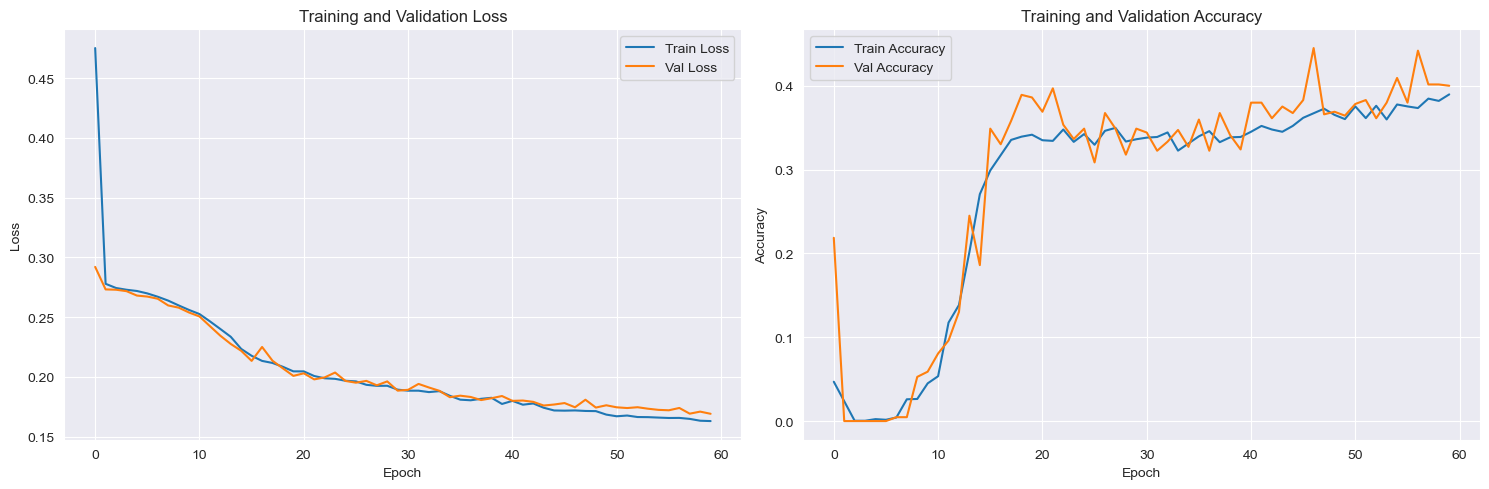


Testing model...
TEST RESULTS
Overall Accuracy: 0.3610
Number of samples: 3224

Per-class Metrics:
Class 0: Precision=0.4908, Recall=0.4106, F1=0.4471
Class 1: Precision=0.5298, Recall=0.2235, F1=0.3143
Class 2: Precision=0.6154, Recall=0.5502, F1=0.5810
Class 3: Precision=0.8104, Recall=0.8662, F1=0.8374

Compound Fault Analysis:
Number of compound fault samples: 360
Compound fault predictions distribution:
  Prediction [0. 0. 0. 0.]: 94 samples (26.1%)
  Prediction [0. 0. 0. 1.]: 146 samples (40.6%)
  Prediction [0. 0. 1. 0.]: 21 samples (5.8%)
  Prediction [0. 0. 1. 1.]: 18 samples (5.0%)
  Prediction [0. 1. 0. 0.]: 27 samples (7.5%)
  Prediction [1. 0. 0. 1.]: 40 samples (11.1%)
  Prediction [1. 0. 1. 0.]: 1 samples (0.3%)
  Prediction [1. 0. 1. 1.]: 12 samples (3.3%)
  Prediction [1. 1. 1. 0.]: 1 samples (0.3%)
Compound fault decoupling accuracy: 0.0500

Sample lengths for compound faults (first 5 samples):
  Sample 0: [0.46660346 0.53130686 0.6163067  0.7441518 ]
  Sample 1: [0.

In [132]:
# -------------------------
# 10) 修改后的主函数
# -------------------------
def main():
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 加载数据
    print("Loading data...")
    train_data, train_labels, test_data, test_labels = load_and_prepare_data()

    if train_data is None:
        print("Data loading failed. Exiting.")
        return

    # 创建数据集
    train_dataset = VibrationDataset(train_data, train_labels)
    test_dataset = VibrationDataset(test_data, test_labels)

    # 分割训练数据用于验证
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 初始化模型
    model = DDCNN(num_classes=4, capsule_rd=16, routing_iters=3).to(device)

    # 打印模型摘要
    print("\nModel Summary:")
    print(f"Feature extractor: {model.feature_extractor}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

    # 训练模型
    print("\nStarting training...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_ddcnn(
        model, train_loader, val_loader, device, num_epochs=60
    )

    # 绘制训练历史
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

    # 测试模型
    print("\nTesting model...")
    accuracy, predictions, true_labels, class_metrics = test_ddcnn(model, test_loader, device)

    # 保存模型
    torch.save({
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': accuracy
    }, 'ddcnn_model_complete.pth')
    print("Model saved as 'ddcnn_model_complete.pth'")

if __name__ == "__main__":
    main()

In [112]:
# -------------------------
# 10) Visualization and Analysis
# -------------------------
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_features(model, data_loader, device):
    """Visualize learned features using t-SNE"""
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)

            # Get features before decoupling classifier
            feats = model.feature_extractor(batch_data)
            features_list.append(feats.cpu().numpy())
            labels_list.append(batch_labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # Reshape features for t-SNE
    features_flat = features.reshape(features.shape[0], -1)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features_flat)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=np.argmax(labels, axis=1), cmap='tab10')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Learned Features')
    plt.show()

def calculate_feature_metrics(model, data_loader, device):
    """Calculate feature separation metrics (J1-J4 from paper)"""
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            feats = model.feature_extractor(batch_data)
            features_list.append(feats.cpu().numpy())
            labels_list.append(batch_labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    features_flat = features.reshape(features.shape[0], -1)

    # Calculate Sb and Sw (between-class and within-class covariance)
    # Implementation of equations (13)-(16) from the paper
    # ... (implementation details based on your specific needs)

    return features_flat, labels